<a href="https://colab.research.google.com/github/canfielder/DSBA-6190_Proj2/blob/master/wine_predict/wine_quality_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [376]:
import sys
!{sys.executable} -m pip install joblib

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Modeling
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Output
from sklearn.metrics import mean_squared_error,r2_score

# Export
#from sklearn.externals import joblib

seed = 5590

# Data Import

In [0]:
# URL Shortened Github link
url = 'https://bit.ly/39kKCWZ'
df_wine_red = pd.read_csv(url, sep=";")

# EDA

In [379]:
df_wine_red.shape

(1599, 12)

In [380]:
df_wine_red.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

## Remove spaces from column names

In [0]:
df_wine_red.columns = df_wine_red.columns.str.replace(' ', '_')

In [382]:
df_wine_red.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [383]:
df_wine_red.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## Missing Value Check

In [384]:
df_wine_red.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Inspect Multicollinearity
All of the variables are numeric. We need to verify that there is no multicollinearity.

In [385]:
correlations = df_wine_red.corr()['quality'].drop('quality')
print(correlations)

fixed_acidity           0.124052
volatile_acidity       -0.390558
citric_acid             0.226373
residual_sugar          0.013732
chlorides              -0.128907
free_sulfur_dioxide    -0.050656
total_sulfur_dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
Name: quality, dtype: float64


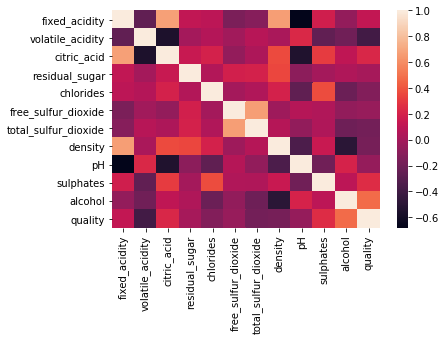

In [386]:
sns.heatmap(df_wine_red.corr())
plt.show()

For now mulitcollinarity will be ignored as this model is just to show how to use a predictive model in a Docker hub. The applicability of the model is not essential.


## Anova Report

In [387]:
results = ols('quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + +chlorides + pH + free_sulfur_dioxide + total_sulfur_dioxide + density + sulphates + alcohol', data=df_wine_red).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.35
Date:                Mon, 10 Feb 2020   Prob (F-statistic):          1.79e-145
Time:                        01:35:37   Log-Likelihood:                -1569.1
No. Observations:                1599   AIC:                             3162.
Df Residuals:                    1587   BIC:                             3227.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               21.9652     21.195      1.036      0.300     -19.607      63.538
fixed_acidity            0.0250      0.026      0.963      0.336      -0.026       0.076
volatile_acidity        -1.0836      0.121     -8.948      0.000      -1.321      -0.846
citric_acid             -0.1826      0.147     -1.240      0.215      -0.471       0.106
residual_sugar           0.0163      0.015      1.089      0.276      -0.013       0.046
chlorides               -1.8742      0.419     -4.470      0.000      -2.697      -1.052
pH                      -0.4137      0.192     -2.159      0.031      -0.789      -0.038
free_sulfur_dioxide      0.0044      0.002      2.009      0.045       0.000       0.009
total_sulfur_dioxide    -0.0033      0.001     -4.480      0.000      -0.005      -0.002
density                -17.8812     21.633     -0.827      0.409     -60.314      24.551
sulphates                0.9163      0.114      8.014      0.000       0.692       1.141
alcohol                  0.2762      0.026     10.429      0.000       0.224       0.328
==============================================================================
Omnibus:                       27.376   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.965
Skew:                          -0.168   Prob(JB):                     1.27e-09
Kurtosis:                       3.708   Cond. No.                     1.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Prepare Data for Modeling

## Seperate Dependent and Independent Variables

In [0]:
y = df_wine_red.quality
X = df_wine_red.drop('quality', axis=1)

In [389]:
X.shape

(1599, 11)

In [390]:
y.shape

(1599,)

## Split Data Into Training and Test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=rs, 
                                                    stratify=y)


## Scale Data


In [0]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [393]:
X_train_scaled = scaler.transform(X_train)
 
print(X_train_scaled.mean(axis=0))
print(X_train_scaled.std(axis=0))

[ 5.33323711e-16 -4.02770511e-17  1.11109106e-17 -1.80552298e-17
  1.80552298e-16 -6.11100085e-17 -8.88872852e-17  4.34631047e-14
  1.40344690e-15  3.83326417e-16 -1.23608881e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [394]:
X_test_scaled = scaler.transform(X_test)

print(X_test_scaled.mean(axis=0))
print(X_test_scaled.std(axis=0))

[-0.1274238  -0.04357722 -0.06045835 -0.02739073 -0.06217043  0.08601355
  0.12611216 -0.08237321  0.06812566  0.14357303  0.0102217 ]
[0.96539711 1.04651894 0.96743984 0.79423727 0.97446725 1.01210074
 1.04851777 0.9260575  0.95588771 1.17597523 0.98535924]


# Modeling

## Linear Regression

In [0]:
lin_reg = LinearRegression()
lin_reg = lin_reg.fit(X_train_scaled, y_train)
y_pred = lin_reg.predict(X_test_scaled)

### Evaluate

In [396]:
print("RMSE for Linear Regression: %.2f" %np.sqrt(mean_squared_error(y_test,y_pred)))
print("r2 for Linear Regression: %.2f" %np.sqrt(r2_score(y_test,y_pred)))

RMSE for Linear Regression: 0.66
r2 for Linear Regression: 0.57


## Random Forest Regressor

The following block develops a pipeline.

In [397]:
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=100, random_state = seed))

hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

num_folds = 10
kfold = KFold(n_splits=num_folds)

grid_result = GridSearchCV(pipeline, hyperparameters, cv=kfold, refit=True)
grid_result.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                             

In [398]:
print(grid_result.best_params_)
rf_reg = grid_result.best_estimator_

{'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'sqrt'}


In [0]:
y_pred = rf_reg.predict(X_test)

### Evaluate

In [400]:
print("RMSE for  RF Regressor: %.2f" %np.sqrt(mean_squared_error(y_test,y_pred)))
print("r2 for RF Regressor: %.2f" %np.sqrt(r2_score(y_test,y_pred)))

RMSE for  RF Regressor: 0.57
r2 for RF Regressor: 0.71


## Gradient Boost Regression


In [0]:
num_folds = 10

model =  GradientBoostingRegressor(random_state=seed)
param_grid={
     'n_estimators': np.linspace(350,500,7).astype(int)           }
kfold = KFold(n_splits=num_folds)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, refit=True)
grid_result = grid.fit(X_train_scaled, y_train)

In [0]:
print(grid_result.best_params_)
grad_boost_reg = grid_result.best_estimator_

### Grid Search Results

In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Fit Model

In [0]:
y_pred = grad_boost_reg.predict(X_test_scaled)

### Evaluate

In [0]:
print("RMSE for Linear Regression: %.2f" %np.sqrt(mean_squared_error(y_test,y_pred)))
print("r2 for Linear Regression: %.2f" %np.sqrt(r2_score(y_test,y_pred)))

# Pickling Sklearn Model
The Random Forest Regressor returned the best model, so we will pickle the model to export for our Flask App.

In [0]:
joblib.dump(rf_reg, 'wine_quality_prediction.joblib')